In [1]:
import os
import numpy as np
import pandas as pd
import torch
import random
import matplotlib.pyplot as plt
import mlflow

import wandb

import time
from datetime import datetime
from pytz import timezone

from utils import seed_everything, plot_explain, data_load, explain_image
from data import categorical_feature,assess_count,\
    feature_engineering,custom_train_test_split,percentile,time_feature_engineering

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.callbacks import Callback

from mlflow_util import MLCallback,connect_server


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parameter Class 설정

In [2]:
FEATS = ['userID','assessmentItemID','testId','KnowledgeTag','Timediff','Time_answer_rate',
         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum','prev_answer','prev_answer_rate','answerCode']
class CFG:
    SEED = 42
    N_EPOCHS = 10
    BATCH_SZ = 1024
    PATIENCE = 3
    VIRTUAL_BS = 128 
    # Ghost batch normalization의 배치사이즈, Batch size의 약수여야함
    LR = 0.01
    ND = 8  # prediction layer dim 크기
    NA = 8  # attention layer dim 크기, ND와 같이 하는게 좋다고 함
    N_STEPS = 3 # step 수 (usually between 3 and 10)
    GAMMA = 1.3 # mask 재사용 정도를 조정하는 파라미터, 1에 가까울 수록 재사용 안함
    #Values range from 1.0 to 2.0.
    N_INDEPENDENT = 2 # Feature transformer의 독립적으로 사용하는 GLU개수 (1~5)
    LAMBDA = 0 # loss에 mask의 sparse 정도를 전달해주는 파라미터
    # 클수록 feature selection 단계에서 sparse하게 선택한다고 함
    N_SHARED = 3 # Feature transformer의 공유하며 사용하는 GLU개수 (1~5)
    MOMENTUM = 0.1
    CLIP = 1.0
    CAT_EMB_DIM = 2
    MASK_TYPE = 'sparsemax' #(default='sparsemax') Either "sparsemax" or "entmax" : this is the masking function to use for selecting features
    DATA_PATH = '../../data/'

### Feature_engineering, train_test_split

In [3]:
def big_cat(data):
    data['big_cat'] = data['testId'].str[2]
    data_big = data.groupby('big_cat').agg({'answerCode':percentile}).reset_index()
    data_big.columns = ['big_cat','big_cat_rate']
    data = data.merge(data_big,how = 'left',on = 'big_cat')
    return data

In [4]:
def add_date(data):
    data['year'] = data['Timestamp'].apply(lambda x : x.year)
    data['month'] = data['Timestamp'].apply(lambda x : x.month)
    data['day'] = data['Timestamp'].apply(lambda x : x.day)
    date_answer_rate = data.groupby(['year','month','day']).agg({'answerCode':percentile}).reset_index()
    date_answer_rate.columns = ['year','month','day','date_answer_rate']
    data = data.merge(date_answer_rate,how = 'left',on = ['year','month','day'])
    data.drop(columns = ['year','day'],inplace = True)
    return data

In [5]:
seed_everything(CFG.SEED)

cat_features = ['userID','assessmentItemID','testId','KnowledgeTag','prev_answer']
# data load
df = data_load(CFG.DATA_PATH)

# time feature engineering
df = assess_count(df)
df = time_feature_engineering(df)
df = add_date(df)
df['prev_answer'] = df.answerCode.shift(1)
# feature engineering
df = feature_engineering(df)
df.fillna(0,inplace = True)
df_prev = df.groupby(['userID','prev_answer']).agg({'answerCode':percentile}).reset_index()
df_prev.columns = ['userID','prev_answer','prev_answer_rate']
df_ar = df.groupby('userID').agg({'answerCode':percentile}).reset_index()
df_ar.columns = ['userID','ar']
df = df.merge(df_prev,how = 'left',on = ['userID','prev_answer'])
df = df.merge(df_ar,how = 'left',on = ['userID'])
df['prev_answer_rate'] = df['prev_answer_rate'] - df['ar']
df.drop(columns = 'ar',inplace =True)
df = big_cat(df)
df = categorical_feature(df,cat_features)

### Data -> train,valid,test

In [6]:
# train test split
train = df[df['answerCode']>-1]
test = df[df['answerCode']==-1]
train,valid = custom_train_test_split(train)

### 사용 Feature 설정

In [7]:
# 유저, 문제, 시험지, 태그 추가
train_set = train[FEATS]
valid_set = valid[FEATS]
cat_idxs = [train_set.columns.get_loc(col) for col in cat_features]
cat_dims = [df[col].nunique() for col in cat_features]

In [8]:
# feature 전부
# FEATS = ['userID','assessmentItemID','testId','KnowledgeTag','Time','Timediff','Timepassed','Time_answer_rate','assess_count',
#          'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum','big_cat','month','date_answer_rate','prev_answer','prev_answer_rate','answerCode']
# train_set = train[FEATS]
# valid_set = valid[FEATS]
# cat_idxs = [train_set.columns.get_loc(col) for col in cat_features]
# cat_dims = [df[col].nunique() for col in cat_features]

### TabNet 불러오기

In [9]:
model = TabNetClassifier(
    seed = CFG.SEED,
    n_d = CFG.ND,
    n_a = CFG.NA,
    n_steps = CFG.N_STEPS,
    gamma = CFG.GAMMA, 
    n_independent = CFG.N_INDEPENDENT,
    n_shared = CFG.N_SHARED,
    cat_emb_dim=CFG.CAT_EMB_DIM,
    optimizer_params=dict(lr=CFG.LR),
    momentum=CFG.MOMENTUM,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    verbose=1,
    scheduler_params=dict(milestones=[20, 50, 80], gamma=0.5), 
    scheduler_fn=torch.optim.lr_scheduler.MultiStepLR,
    mask_type = CFG.MASK_TYPE,
    lambda_sparse = CFG.LAMBDA,
    clip_value = CFG.CLIP
)

/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


### MLflow 불러오기

In [10]:
now = datetime.now(tz = timezone('Asia/Seoul'))
date_str = now.strftime('%m-%d-%H:%M:%S')
remote_server_uri,experiment_id = connect_server()
ml_callback = MLCallback
run_name="파라미터 조정 + feature 줄이기 + 이전문제 정답만"+date_str
desc=",".join(FEATS)
mlflow.end_run()

### 모델 학습

In [11]:
model.fit(
    X_train = train_set.drop(columns = 'answerCode').values,
    y_train = train_set['answerCode'].values,
    eval_set = [(train_set.drop(columns = 'answerCode').values,train_set['answerCode'].values),(valid_set.drop(columns = 'answerCode').values,valid_set['answerCode'].values)],
    eval_name = ['train','valid'],
    eval_metric = ['accuracy','auc'],
    max_epochs = CFG.N_EPOCHS, 
    patience = CFG.PATIENCE,
    batch_size = CFG.BATCH_SZ, 
    virtual_batch_size = CFG.VIRTUAL_BS,
    num_workers = 0,
    weights = 1,
    drop_last = False,
    callbacks=[ml_callback(remote_server_uri, experiment_id, run_name, desc, model.get_params())]
)

epoch 0  | loss: 0.57324 | train_accuracy: 0.72489 | train_auc: 0.77324 | valid_accuracy: 0.67069 | valid_auc: 0.7318  |  0:02:48s
epoch 1  | loss: 0.55793 | train_accuracy: 0.73933 | train_auc: 0.80365 | valid_accuracy: 0.70559 | valid_auc: 0.77146 |  0:05:40s
epoch 2  | loss: 0.52483 | train_accuracy: 0.76269 | train_auc: 0.82718 | valid_accuracy: 0.71096 | valid_auc: 0.78854 |  0:08:33s
epoch 3  | loss: 0.50818 | train_accuracy: 0.75959 | train_auc: 0.83636 | valid_accuracy: 0.69888 | valid_auc: 0.7913  |  0:11:25s
epoch 4  | loss: 0.49874 | train_accuracy: 0.76649 | train_auc: 0.8404  | valid_accuracy: 0.69978 | valid_auc: 0.78934 |  0:14:17s
epoch 5  | loss: 0.49273 | train_accuracy: 0.77294 | train_auc: 0.84558 | valid_accuracy: 0.69396 | valid_auc: 0.79397 |  0:17:10s
epoch 6  | loss: 0.48749 | train_accuracy: 0.77166 | train_auc: 0.84833 | valid_accuracy: 0.69262 | valid_auc: 0.7861  |  0:20:02s
epoch 7  | loss: 0.48533 | train_accuracy: 0.77483 | train_auc: 0.85067 | valid_acc

/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


### 모델 저장 및 불러오기

In [12]:
# save tabnet model
saving_path_name = "./saved/tabnet_" + date_str
model.save_model(saving_path_name)

Successfully saved model at ./saved/tabnet_12-07-15:52:46.zip


'./saved/tabnet_12-07-15:52:46.zip'

In [13]:
# define new model with basic parameters and load state dict weights
# saving_path_name = "./saved/tabnet_12-04 19:19:04"
# model = TabNetClassifier()
# model.load_model(saving_path_name + '.zip')

### Test set Prediction

In [14]:
valid_proba =  model.predict_proba(valid_set[FEATS].drop(columns = 'answerCode').values)
valid_preds =  model.predict(valid_set[FEATS].drop(columns = 'answerCode').values)
valid_auc = roc_auc_score(valid_set['answerCode'],valid_proba[:,1])
valid_acc = accuracy_score(valid_set['answerCode'],valid_preds)

### submission 저장

In [15]:
total_preds = model.predict_proba(test[FEATS].drop(columns = 'answerCode').values)[:,1]
submission = pd.read_csv('../../data/sample_submission.csv')
submission['prediction'] = total_preds
submission.to_csv('./submission/submission'+date_str+'.csv')

### feature_importance

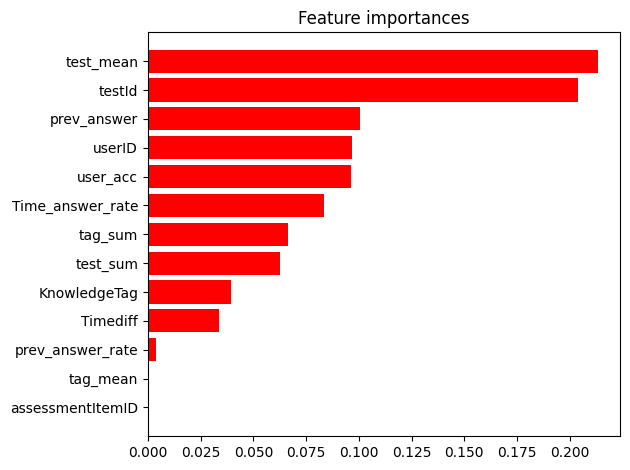

In [16]:
from utils import fi_image
feat_importances = model.feature_importances_
indices = np.argsort(feat_importances)
fi_image(feat_importances,indices,FEATS,experiment_id)

### Explain

In [17]:
explain, masks = model.explain(valid_set.drop(columns = 'answerCode').values)
# np.savez('./explain/'+date_str,explain = explain,mask0 = masks[0],mask1=masks[1],mask2 = masks[2])

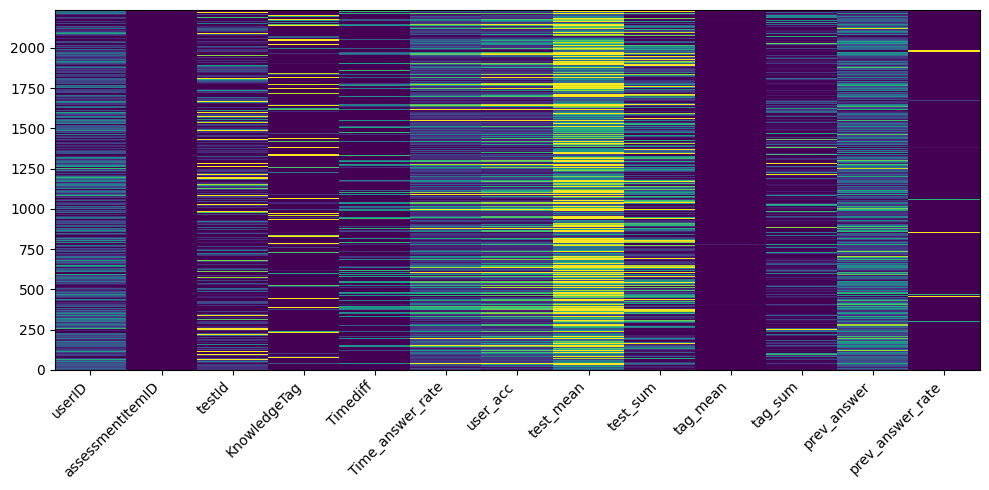

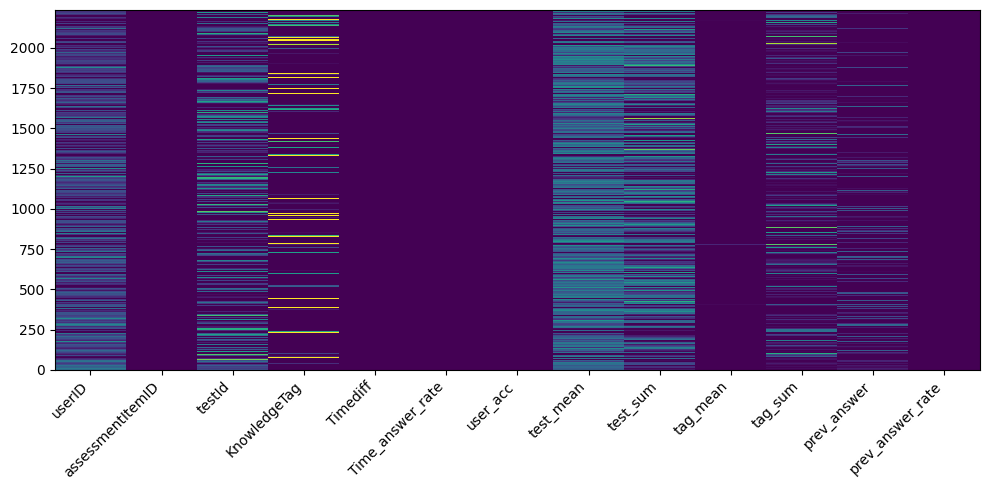

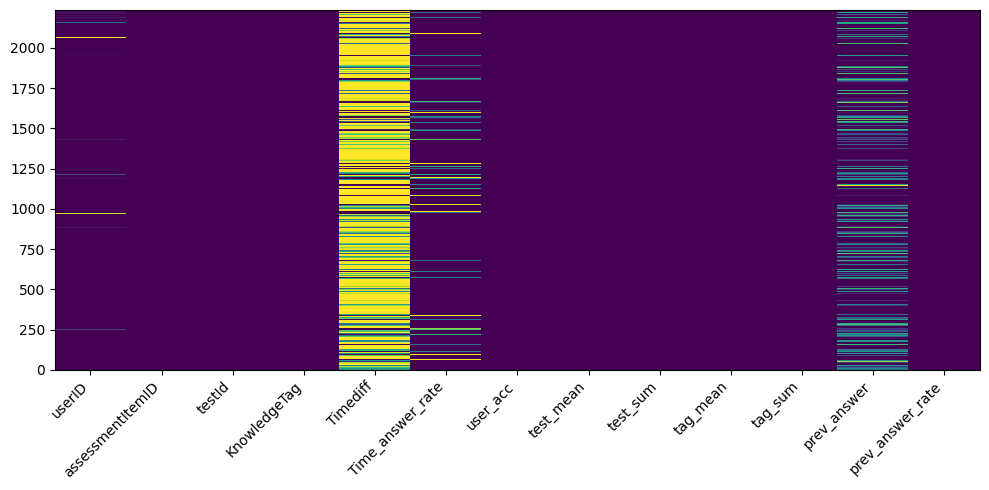

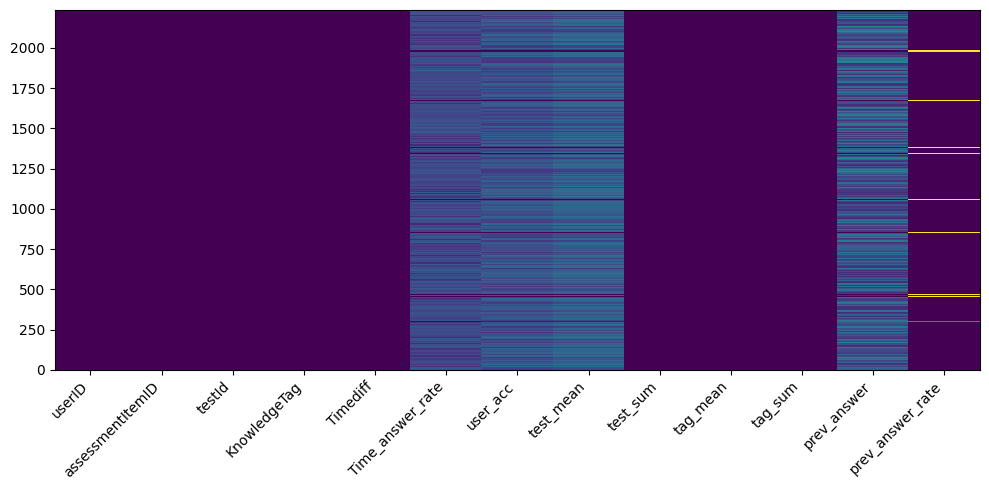

In [18]:
explain_image(explain,masks,FEATS,experiment_id)